In [1]:
import network
import optuna
import pickle
import load_data as ld
from sklearn_extra.cluster import KMedoids
from pathlib import Path
from sklearn.exceptions import NotFittedError
from slope_calculation import *

In [2]:
def define_number_of_clusters(z, path):
    inertia_score = []
    for i in range(2, 11):
        clusterer = KMedoids(n_clusters=i, random_state=0, method='pam').fit(z)
        inertia_score.append(clusterer.inertia_)

    inertia_score = inertia_score/max(inertia_score)
    plt.figure()
    plt.plot(list(range(2, 11)), inertia_score, "-*")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Sum of Distances from Centroid (Normalized)")
    plt.xticks(list(range(2, 11)), list(range(2, 11)))
    plt.savefig(path + 'Define Clusters.svg')
    plt.savefig(path + 'Define Clusters.png')
    plt.show()

In [12]:
# define the paths that the data exist and tha path to save the results
parent_folder = Path(os.getcwd()).parent.absolute()
data_path = os.path.join(parent_folder, "Data/FLEMENGHO/Strain curves - Sfile16 (Filtered)")
save_data_path = os.path.join(parent_folder,"Results/AE_k-medoids/FLEMENGHO/")

# create save_data_path directory if not exist
if not os.path.exists(save_data_path):
    os.makedirs(save_data_path)

# manual annotation of the Aortic Valve Closure
avc_files = ["Data/FLEMENGHO/AVC time_16_all.xlsx",
             "Data/FLEMENGHO/Patients Without AVC_TK.xlsx"]

# manual annotation of the P-wave in the ECG
marker_file = ["Data/FLEMENGHO/Patients for manual annotation of markers_TK.xlsx"]

In [13]:
# read the time, strain and ECG data from the .txt files
original_data, data, patient_id, interval = ld.read_data(data_path)

# Obtain the time AVC from the respective .xlsx file, as annotated manually be an expert
# IDs of patients that do not have a measurement are included in the "excluded_patients1" variable
excluded_patients1, avc_times = ld.read_avc_time(parent_folder, avc_files)

# Read the time at which the peak of the P-wave occurs, as annotated manually be an expert
# IDs of patients that do not have a measurement are included in the "excluded_patients2" variable
excluded_patients2, p_wave_times = ld.read_p_wave_data(parent_folder, marker_file)

# Remove from the time, strain and ECG data, the measurements that correspond to IDS that should be excluded
original_data, data, patient_id, interval = exclude_patients(excluded_patients1, excluded_patients2, original_data,
                                                             data, patient_id, interval)

# Align the ECG and the strain curves based on a reference signal.
decision = "peak"
reference_patient_id = "1687"
aligned_ecg, deformation, reference_index, normalized_time, reference_time = get_aligned_signals(original_data,
                                                                                                 decision, interval,
                                                                                                 patient_id,reference_patient_id,
                                                                                                 avc_times, p_wave_times)

deformation = np.array(deformation)

C:\Users\vagge\Desktop\Deformation Curves\VAE\load_data.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_excel(f, usecols=(0, 1)), ignore_index=True)
C:\Users\vagge\Desktop\Deformation Curves\VAE\load_data.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_excel(f, usecols=(0, 1)), ignore_index=True)
C:\Users\vagge\Desktop\Deformation Curves\VAE\load_data.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_excel(f, usecols=(0, 1, 2)), ignore_index=True)


Start slicing data
Start Alignment


In [5]:
# train from scratch and save the best AE model and its weights
study = optuna.create_study(direction='minimize')
study.optimize(lambda n_trial: network.objective(n_trial, deformation, save_data_path), n_trials=100)

autoencoder = keras.models.load_model(save_data_path+"Trial Models/{}.h5".format(study.best_trial.number),
                                      compile=False)

# save the model of autoencoder
autoencoder.save(os.path.join(parent_folder,"Results/AE_k-medoids/AE Model"))
try:
    autoencoder.save_weights(os.path.join(parent_folder,"Results/AE_k-medoids/AE Model/autoencoder_weights"))
except Exception:
    print("Weights are not saved.")

[I 2022-04-14 12:58:07,265] A new study created in memory with name: no-name-5674586f-ea43-4215-b932-cdbb20f9132a
[I 2022-04-14 12:58:22,814] Trial 0 finished with value: 6.08675479888916 and parameters: {'latent dimension': 3, 'Convolutional Layer': 5, 'Hidden Layer': 5, 'f1': 16, 'k1': 3, 'activations': 'elu', 'f2': 32, 'k2': 3, 'f3': 32, 'k3': 3, 'f4': 32, 'k4': 5, 'f5': 64, 'k5': 3, 'l1': 32, 'l2': 16, 'l3': 16, 'l4': 16, 'l5': 32}. Best is trial 0 with value: 6.08675479888916.
[I 2022-04-14 12:58:40,424] Trial 1 finished with value: 6.591963768005371 and parameters: {'latent dimension': 5, 'Convolutional Layer': 5, 'Hidden Layer': 5, 'f1': 32, 'k1': 3, 'activations': 'relu', 'f2': 32, 'k2': 3, 'f3': 16, 'k3': 7, 'f4': 64, 'k4': 7, 'f5': 32, 'k5': 7, 'l1': 32, 'l2': 64, 'l3': 32, 'l4': 32, 'l5': 16}. Best is trial 0 with value: 6.08675479888916.
[I 2022-04-14 12:58:45,478] Trial 2 finished with value: 1.636847734451294 and parameters: {'latent dimension': 5, 'Convolutional Layer': 

Restoring model weights from the end of the best epoch: 7.
Epoch 17: early stopping


[I 2022-04-14 13:00:11,186] Trial 8 finished with value: 7.420863151550293 and parameters: {'latent dimension': 2, 'Convolutional Layer': 5, 'Hidden Layer': 5, 'f1': 32, 'k1': 5, 'activations': 'linear', 'f2': 32, 'k2': 7, 'f3': 32, 'k3': 7, 'f4': 16, 'k4': 7, 'f5': 64, 'k5': 7, 'l1': 16, 'l2': 32, 'l3': 64, 'l4': 32, 'l5': 64}. Best is trial 3 with value: 1.4050763845443726.


Restoring model weights from the end of the best epoch: 2.
Epoch 12: early stopping


[I 2022-04-14 13:00:18,011] Trial 9 finished with value: 17.24411964416504 and parameters: {'latent dimension': 4, 'Convolutional Layer': 5, 'Hidden Layer': 4, 'f1': 64, 'k1': 3, 'activations': 'relu', 'f2': 64, 'k2': 5, 'f3': 16, 'k3': 5, 'f4': 16, 'k4': 3, 'f5': 32, 'k5': 3, 'l1': 16, 'l2': 32, 'l3': 32, 'l4': 16}. Best is trial 3 with value: 1.4050763845443726.
[I 2022-04-14 13:00:33,432] Trial 10 finished with value: 2.7645277976989746 and parameters: {'latent dimension': 3, 'Convolutional Layer': 3, 'Hidden Layer': 3, 'f1': 64, 'k1': 7, 'activations': 'elu', 'f2': 16, 'k2': 5, 'f3': 64, 'k3': 3, 'l1': 64, 'l2': 16, 'l3': 16}. Best is trial 3 with value: 1.4050763845443726.
[I 2022-04-14 13:00:44,691] Trial 11 finished with value: 1.702160120010376 and parameters: {'latent dimension': 5, 'Convolutional Layer': 2, 'Hidden Layer': 4, 'f1': 32, 'k1': 5, 'activations': 'linear', 'f2': 64, 'k2': 7, 'l1': 16, 'l2': 16, 'l3': 32, 'l4': 64}. Best is trial 3 with value: 1.4050763845443726.


Restoring model weights from the end of the best epoch: 11.
Epoch 21: early stopping


[I 2022-04-14 13:01:22,933] Trial 17 finished with value: 7.268186569213867 and parameters: {'latent dimension': 2, 'Convolutional Layer': 4, 'Hidden Layer': 3, 'f1': 64, 'k1': 7, 'activations': 'linear', 'f2': 16, 'k2': 5, 'f3': 32, 'k3': 5, 'f4': 16, 'k4': 3, 'l1': 32, 'l2': 16, 'l3': 64}. Best is trial 15 with value: 1.390137791633606.
[I 2022-04-14 13:01:27,795] Trial 18 finished with value: 3.512538433074951 and parameters: {'latent dimension': 3, 'Convolutional Layer': 1, 'Hidden Layer': 2, 'f1': 32, 'k1': 7, 'activations': 'linear', 'l1': 64, 'l2': 32}. Best is trial 15 with value: 1.390137791633606.
[I 2022-04-14 13:01:32,597] Trial 19 finished with value: 2.8894424438476562 and parameters: {'latent dimension': 5, 'Convolutional Layer': 1, 'Hidden Layer': 2, 'f1': 32, 'k1': 7, 'activations': 'elu', 'l1': 32, 'l2': 16}. Best is trial 15 with value: 1.390137791633606.


Restoring model weights from the end of the best epoch: 17.
Epoch 27: early stopping


[I 2022-04-14 13:01:42,810] Trial 20 finished with value: 1.4255287647247314 and parameters: {'latent dimension': 5, 'Convolutional Layer': 3, 'Hidden Layer': 2, 'f1': 64, 'k1': 3, 'activations': 'linear', 'f2': 16, 'k2': 5, 'f3': 64, 'k3': 3, 'l1': 32, 'l2': 16}. Best is trial 15 with value: 1.390137791633606.
[I 2022-04-14 13:01:47,075] Trial 21 finished with value: 1.411539912223816 and parameters: {'latent dimension': 5, 'Convolutional Layer': 1, 'Hidden Layer': 2, 'f1': 32, 'k1': 7, 'activations': 'linear', 'l1': 32, 'l2': 16}. Best is trial 15 with value: 1.390137791633606.
[I 2022-04-14 13:01:51,332] Trial 22 finished with value: 1.4423942565917969 and parameters: {'latent dimension': 5, 'Convolutional Layer': 1, 'Hidden Layer': 2, 'f1': 32, 'k1': 7, 'activations': 'linear', 'l1': 32, 'l2': 16}. Best is trial 15 with value: 1.390137791633606.
[I 2022-04-14 13:01:55,593] Trial 23 finished with value: 1.465164303779602 and parameters: {'latent dimension': 5, 'Convolutional Layer':

Restoring model weights from the end of the best epoch: 13.
Epoch 23: early stopping


[I 2022-04-14 13:01:59,028] Trial 24 finished with value: 1.4271833896636963 and parameters: {'latent dimension': 5, 'Convolutional Layer': 1, 'Hidden Layer': 3, 'f1': 32, 'k1': 7, 'activations': 'linear', 'l1': 32, 'l2': 16, 'l3': 16}. Best is trial 15 with value: 1.390137791633606.
[I 2022-04-14 13:02:13,824] Trial 25 finished with value: 1.4421805143356323 and parameters: {'latent dimension': 5, 'Convolutional Layer': 4, 'Hidden Layer': 2, 'f1': 32, 'k1': 7, 'activations': 'linear', 'f2': 16, 'k2': 5, 'f3': 32, 'k3': 7, 'f4': 16, 'k4': 5, 'l1': 64, 'l2': 32}. Best is trial 15 with value: 1.390137791633606.


Restoring model weights from the end of the best epoch: 17.
Epoch 27: early stopping


[I 2022-04-14 13:02:18,640] Trial 26 finished with value: 7.168027877807617 and parameters: {'latent dimension': 2, 'Convolutional Layer': 1, 'Hidden Layer': 2, 'f1': 32, 'k1': 7, 'activations': 'linear', 'l1': 32, 'l2': 16}. Best is trial 15 with value: 1.390137791633606.
[I 2022-04-14 13:02:23,959] Trial 27 finished with value: 2.8788106441497803 and parameters: {'latent dimension': 3, 'Convolutional Layer': 1, 'Hidden Layer': 2, 'f1': 32, 'k1': 7, 'activations': 'relu', 'l1': 32, 'l2': 16}. Best is trial 15 with value: 1.390137791633606.
[I 2022-04-14 13:02:39,275] Trial 28 finished with value: 1.9538501501083374 and parameters: {'latent dimension': 4, 'Convolutional Layer': 5, 'Hidden Layer': 2, 'f1': 32, 'k1': 3, 'activations': 'linear', 'f2': 64, 'k2': 3, 'f3': 32, 'k3': 7, 'f4': 16, 'k4': 3, 'f5': 16, 'k5': 5, 'l1': 32, 'l2': 16}. Best is trial 15 with value: 1.390137791633606.


Restoring model weights from the end of the best epoch: 16.
Epoch 26: early stopping


[I 2022-04-14 13:02:57,336] Trial 29 finished with value: 2.819408655166626 and parameters: {'latent dimension': 3, 'Convolutional Layer': 5, 'Hidden Layer': 3, 'f1': 64, 'k1': 7, 'activations': 'elu', 'f2': 16, 'k2': 5, 'f3': 64, 'k3': 3, 'f4': 64, 'k4': 3, 'f5': 16, 'k5': 5, 'l1': 32, 'l2': 16, 'l3': 16}. Best is trial 15 with value: 1.390137791633606.
[I 2022-04-14 13:03:04,571] Trial 30 finished with value: 1.306636929512024 and parameters: {'latent dimension': 5, 'Convolutional Layer': 3, 'Hidden Layer': 2, 'f1': 16, 'k1': 3, 'activations': 'elu', 'f2': 16, 'k2': 5, 'f3': 16, 'k3': 5, 'l1': 64, 'l2': 32}. Best is trial 30 with value: 1.306636929512024.
[I 2022-04-14 13:03:11,884] Trial 31 finished with value: 1.510172724723816 and parameters: {'latent dimension': 5, 'Convolutional Layer': 3, 'Hidden Layer': 2, 'f1': 16, 'k1': 3, 'activations': 'elu', 'f2': 16, 'k2': 5, 'f3': 16, 'k3': 5, 'l1': 64, 'l2': 32}. Best is trial 30 with value: 1.306636929512024.
[I 2022-04-14 13:03:20,04

Restoring model weights from the end of the best epoch: 17.
Epoch 27: early stopping


[I 2022-04-14 13:04:15,141] Trial 39 finished with value: 7.269927501678467 and parameters: {'latent dimension': 2, 'Convolutional Layer': 2, 'Hidden Layer': 5, 'f1': 16, 'k1': 3, 'activations': 'linear', 'f2': 16, 'k2': 5, 'l1': 64, 'l2': 16, 'l3': 16, 'l4': 16, 'l5': 16}. Best is trial 30 with value: 1.306636929512024.
[I 2022-04-14 13:04:20,305] Trial 40 finished with value: 1.5345247983932495 and parameters: {'latent dimension': 5, 'Convolutional Layer': 2, 'Hidden Layer': 2, 'f1': 16, 'k1': 3, 'activations': 'linear', 'f2': 16, 'k2': 5, 'l1': 64, 'l2': 32}. Best is trial 30 with value: 1.306636929512024.


Restoring model weights from the end of the best epoch: 17.
Epoch 27: early stopping


[I 2022-04-14 13:04:24,777] Trial 41 finished with value: 1.4987425804138184 and parameters: {'latent dimension': 5, 'Convolutional Layer': 2, 'Hidden Layer': 2, 'f1': 16, 'k1': 3, 'activations': 'linear', 'f2': 16, 'k2': 5, 'l1': 64, 'l2': 16}. Best is trial 30 with value: 1.306636929512024.
[I 2022-04-14 13:04:36,631] Trial 42 finished with value: 1.4077835083007812 and parameters: {'latent dimension': 5, 'Convolutional Layer': 5, 'Hidden Layer': 2, 'f1': 16, 'k1': 5, 'activations': 'linear', 'f2': 32, 'k2': 3, 'f3': 16, 'k3': 5, 'f4': 16, 'k4': 3, 'f5': 32, 'k5': 5, 'l1': 64, 'l2': 16}. Best is trial 30 with value: 1.306636929512024.


Restoring model weights from the end of the best epoch: 18.
Epoch 28: early stopping


[I 2022-04-14 13:04:47,278] Trial 43 finished with value: 1.4324413537979126 and parameters: {'latent dimension': 5, 'Convolutional Layer': 5, 'Hidden Layer': 2, 'f1': 16, 'k1': 5, 'activations': 'linear', 'f2': 32, 'k2': 3, 'f3': 16, 'k3': 5, 'f4': 16, 'k4': 3, 'f5': 32, 'k5': 5, 'l1': 64, 'l2': 16}. Best is trial 30 with value: 1.306636929512024.
[I 2022-04-14 13:04:59,855] Trial 44 finished with value: 1.4860541820526123 and parameters: {'latent dimension': 5, 'Convolutional Layer': 5, 'Hidden Layer': 2, 'f1': 16, 'k1': 5, 'activations': 'linear', 'f2': 32, 'k2': 3, 'f3': 16, 'k3': 5, 'f4': 16, 'k4': 3, 'f5': 32, 'k5': 5, 'l1': 64, 'l2': 16}. Best is trial 30 with value: 1.306636929512024.
[I 2022-04-14 13:05:11,594] Trial 45 finished with value: 1.408583402633667 and parameters: {'latent dimension': 5, 'Convolutional Layer': 5, 'Hidden Layer': 4, 'f1': 16, 'k1': 5, 'activations': 'linear', 'f2': 32, 'k2': 3, 'f3': 16, 'k3': 5, 'f4': 16, 'k4': 3, 'f5': 32, 'k5': 5, 'l1': 64, 'l2': 1

Restoring model weights from the end of the best epoch: 20.
Epoch 30: early stopping


[I 2022-04-14 13:05:52,994] Trial 48 finished with value: 1.6113988161087036 and parameters: {'latent dimension': 4, 'Convolutional Layer': 5, 'Hidden Layer': 2, 'f1': 16, 'k1': 5, 'activations': 'elu', 'f2': 32, 'k2': 7, 'f3': 64, 'k3': 3, 'f4': 64, 'k4': 5, 'f5': 16, 'k5': 3, 'l1': 16, 'l2': 16}. Best is trial 30 with value: 1.306636929512024.


Restoring model weights from the end of the best epoch: 18.
Epoch 28: early stopping


[I 2022-04-14 13:06:00,598] Trial 49 finished with value: 7.199552059173584 and parameters: {'latent dimension': 2, 'Convolutional Layer': 2, 'Hidden Layer': 2, 'f1': 64, 'k1': 3, 'activations': 'linear', 'f2': 16, 'k2': 3, 'l1': 64, 'l2': 16}. Best is trial 30 with value: 1.306636929512024.
[I 2022-04-14 13:06:14,392] Trial 50 finished with value: 1.4276554584503174 and parameters: {'latent dimension': 5, 'Convolutional Layer': 5, 'Hidden Layer': 2, 'f1': 16, 'k1': 3, 'activations': 'linear', 'f2': 32, 'k2': 7, 'f3': 16, 'k3': 5, 'f4': 16, 'k4': 3, 'f5': 32, 'k5': 5, 'l1': 64, 'l2': 32}. Best is trial 30 with value: 1.306636929512024.


Restoring model weights from the end of the best epoch: 19.
Epoch 29: early stopping


[I 2022-04-14 13:06:25,299] Trial 51 finished with value: 1.4428383111953735 and parameters: {'latent dimension': 5, 'Convolutional Layer': 5, 'Hidden Layer': 4, 'f1': 16, 'k1': 5, 'activations': 'linear', 'f2': 32, 'k2': 3, 'f3': 16, 'k3': 5, 'f4': 16, 'k4': 3, 'f5': 32, 'k5': 5, 'l1': 64, 'l2': 16, 'l3': 64, 'l4': 64}. Best is trial 30 with value: 1.306636929512024.


Restoring model weights from the end of the best epoch: 20.
Epoch 30: early stopping


[I 2022-04-14 13:06:36,573] Trial 52 finished with value: 1.4336585998535156 and parameters: {'latent dimension': 5, 'Convolutional Layer': 5, 'Hidden Layer': 4, 'f1': 16, 'k1': 5, 'activations': 'linear', 'f2': 32, 'k2': 3, 'f3': 16, 'k3': 5, 'f4': 16, 'k4': 3, 'f5': 32, 'k5': 5, 'l1': 64, 'l2': 16, 'l3': 64, 'l4': 64}. Best is trial 30 with value: 1.306636929512024.
[I 2022-04-14 13:06:48,027] Trial 53 finished with value: 1.5971158742904663 and parameters: {'latent dimension': 5, 'Convolutional Layer': 5, 'Hidden Layer': 4, 'f1': 16, 'k1': 5, 'activations': 'linear', 'f2': 32, 'k2': 3, 'f3': 16, 'k3': 5, 'f4': 16, 'k4': 3, 'f5': 32, 'k5': 5, 'l1': 64, 'l2': 16, 'l3': 64, 'l4': 64}. Best is trial 30 with value: 1.306636929512024.


Restoring model weights from the end of the best epoch: 14.
Epoch 24: early stopping


[I 2022-04-14 13:06:56,056] Trial 54 finished with value: 1.5132942199707031 and parameters: {'latent dimension': 5, 'Convolutional Layer': 3, 'Hidden Layer': 4, 'f1': 16, 'k1': 5, 'activations': 'linear', 'f2': 32, 'k2': 3, 'f3': 32, 'k3': 5, 'l1': 64, 'l2': 16, 'l3': 64, 'l4': 64}. Best is trial 30 with value: 1.306636929512024.
[I 2022-04-14 13:07:10,511] Trial 55 finished with value: 1.3995606899261475 and parameters: {'latent dimension': 5, 'Convolutional Layer': 5, 'Hidden Layer': 4, 'f1': 16, 'k1': 5, 'activations': 'linear', 'f2': 64, 'k2': 3, 'f3': 16, 'k3': 7, 'f4': 16, 'k4': 3, 'f5': 32, 'k5': 5, 'l1': 16, 'l2': 16, 'l3': 64, 'l4': 64}. Best is trial 30 with value: 1.306636929512024.
[I 2022-04-14 13:07:29,353] Trial 56 finished with value: 1.4591221809387207 and parameters: {'latent dimension': 5, 'Convolutional Layer': 4, 'Hidden Layer': 4, 'f1': 64, 'k1': 5, 'activations': 'linear', 'f2': 64, 'k2': 5, 'f3': 32, 'k3': 7, 'f4': 16, 'k4': 3, 'l1': 16, 'l2': 64, 'l3': 64, 'l4

Restoring model weights from the end of the best epoch: 7.
Epoch 17: early stopping


[I 2022-04-14 13:10:51,612] Trial 65 finished with value: 7.2914204597473145 and parameters: {'latent dimension': 2, 'Convolutional Layer': 1, 'Hidden Layer': 2, 'f1': 32, 'k1': 7, 'activations': 'linear', 'l1': 16, 'l2': 16}. Best is trial 30 with value: 1.306636929512024.


Restoring model weights from the end of the best epoch: 18.
Epoch 28: early stopping


[I 2022-04-14 13:11:19,967] Trial 66 finished with value: 1.9657140970230103 and parameters: {'latent dimension': 4, 'Convolutional Layer': 5, 'Hidden Layer': 2, 'f1': 32, 'k1': 7, 'activations': 'linear', 'f2': 64, 'k2': 5, 'f3': 16, 'k3': 7, 'f4': 64, 'k4': 5, 'f5': 32, 'k5': 5, 'l1': 16, 'l2': 32}. Best is trial 30 with value: 1.306636929512024.
[I 2022-04-14 13:11:44,445] Trial 67 finished with value: 1.6168032884597778 and parameters: {'latent dimension': 5, 'Convolutional Layer': 3, 'Hidden Layer': 2, 'f1': 32, 'k1': 7, 'activations': 'elu', 'f2': 64, 'k2': 5, 'f3': 64, 'k3': 7, 'l1': 16, 'l2': 16}. Best is trial 30 with value: 1.306636929512024.
[I 2022-04-14 13:12:09,095] Trial 68 finished with value: 1.412717342376709 and parameters: {'latent dimension': 5, 'Convolutional Layer': 4, 'Hidden Layer': 2, 'f1': 32, 'k1': 7, 'activations': 'linear', 'f2': 64, 'k2': 5, 'f3': 32, 'k3': 7, 'f4': 32, 'k4': 5, 'l1': 16, 'l2': 16}. Best is trial 30 with value: 1.306636929512024.


Restoring model weights from the end of the best epoch: 15.
Epoch 25: early stopping


[I 2022-04-14 13:12:14,194] Trial 69 finished with value: 1.4202913045883179 and parameters: {'latent dimension': 5, 'Convolutional Layer': 1, 'Hidden Layer': 2, 'f1': 32, 'k1': 7, 'activations': 'linear', 'l1': 32, 'l2': 32}. Best is trial 30 with value: 1.306636929512024.
[I 2022-04-14 13:12:41,152] Trial 70 finished with value: 1.5111082792282104 and parameters: {'latent dimension': 5, 'Convolutional Layer': 2, 'Hidden Layer': 4, 'f1': 64, 'k1': 3, 'activations': 'linear', 'f2': 64, 'k2': 5, 'l1': 32, 'l2': 16, 'l3': 16, 'l4': 16}. Best is trial 30 with value: 1.306636929512024.
[I 2022-04-14 13:13:01,497] Trial 71 finished with value: 1.4600274562835693 and parameters: {'latent dimension': 5, 'Convolutional Layer': 5, 'Hidden Layer': 2, 'f1': 16, 'k1': 7, 'activations': 'linear', 'f2': 16, 'k2': 5, 'f3': 16, 'k3': 7, 'f4': 16, 'k4': 5, 'f5': 32, 'k5': 5, 'l1': 16, 'l2': 16}. Best is trial 30 with value: 1.306636929512024.
[I 2022-04-14 13:13:22,478] Trial 72 finished with value: 1.

Restoring model weights from the end of the best epoch: 9.
Epoch 19: early stopping


[I 2022-04-14 13:14:32,035] Trial 79 finished with value: 2.0229711532592773 and parameters: {'latent dimension': 4, 'Convolutional Layer': 1, 'Hidden Layer': 3, 'f1': 32, 'k1': 3, 'activations': 'linear', 'l1': 32, 'l2': 16, 'l3': 64}. Best is trial 30 with value: 1.306636929512024.
[I 2022-04-14 13:14:36,748] Trial 80 finished with value: 6.162623405456543 and parameters: {'latent dimension': 2, 'Convolutional Layer': 1, 'Hidden Layer': 3, 'f1': 32, 'k1': 3, 'activations': 'elu', 'l1': 32, 'l2': 16, 'l3': 64}. Best is trial 30 with value: 1.306636929512024.


Restoring model weights from the end of the best epoch: 20.
Epoch 30: early stopping


[I 2022-04-14 13:14:57,008] Trial 81 finished with value: 1.3915443420410156 and parameters: {'latent dimension': 5, 'Convolutional Layer': 3, 'Hidden Layer': 2, 'f1': 16, 'k1': 3, 'activations': 'linear', 'f2': 64, 'k2': 7, 'f3': 64, 'k3': 7, 'l1': 32, 'l2': 16}. Best is trial 30 with value: 1.306636929512024.
[I 2022-04-14 13:15:19,358] Trial 82 finished with value: 1.421002745628357 and parameters: {'latent dimension': 5, 'Convolutional Layer': 3, 'Hidden Layer': 2, 'f1': 32, 'k1': 3, 'activations': 'linear', 'f2': 64, 'k2': 7, 'f3': 64, 'k3': 7, 'l1': 32, 'l2': 16}. Best is trial 30 with value: 1.306636929512024.


Restoring model weights from the end of the best epoch: 19.
Epoch 29: early stopping


[I 2022-04-14 13:15:46,085] Trial 83 finished with value: 1.4219378232955933 and parameters: {'latent dimension': 5, 'Convolutional Layer': 3, 'Hidden Layer': 3, 'f1': 16, 'k1': 3, 'activations': 'linear', 'f2': 64, 'k2': 7, 'f3': 64, 'k3': 7, 'l1': 32, 'l2': 16, 'l3': 32}. Best is trial 30 with value: 1.306636929512024.
[I 2022-04-14 13:16:14,342] Trial 84 finished with value: 1.9176257848739624 and parameters: {'latent dimension': 5, 'Convolutional Layer': 3, 'Hidden Layer': 5, 'f1': 32, 'k1': 3, 'activations': 'linear', 'f2': 64, 'k2': 7, 'f3': 64, 'k3': 7, 'l1': 32, 'l2': 16, 'l3': 64, 'l4': 32, 'l5': 32}. Best is trial 30 with value: 1.306636929512024.
[I 2022-04-14 13:16:37,154] Trial 85 finished with value: 1.4545221328735352 and parameters: {'latent dimension': 5, 'Convolutional Layer': 3, 'Hidden Layer': 2, 'f1': 16, 'k1': 3, 'activations': 'linear', 'f2': 64, 'k2': 7, 'f3': 64, 'k3': 7, 'l1': 32, 'l2': 16}. Best is trial 30 with value: 1.306636929512024.
[I 2022-04-14 13:16:4

Restoring model weights from the end of the best epoch: 20.
Epoch 30: early stopping


[I 2022-04-14 13:16:55,912] Trial 88 finished with value: 1.4258747100830078 and parameters: {'latent dimension': 5, 'Convolutional Layer': 2, 'Hidden Layer': 4, 'f1': 16, 'k1': 3, 'activations': 'linear', 'f2': 16, 'k2': 5, 'l1': 32, 'l2': 16, 'l3': 32, 'l4': 64}. Best is trial 30 with value: 1.306636929512024.
[I 2022-04-14 13:17:07,975] Trial 89 finished with value: 1.4312318563461304 and parameters: {'latent dimension': 5, 'Convolutional Layer': 2, 'Hidden Layer': 4, 'f1': 32, 'k1': 3, 'activations': 'linear', 'f2': 64, 'k2': 5, 'l1': 16, 'l2': 16, 'l3': 32, 'l4': 64}. Best is trial 30 with value: 1.306636929512024.
[I 2022-04-14 13:17:18,138] Trial 90 finished with value: 2.8437843322753906 and parameters: {'latent dimension': 5, 'Convolutional Layer': 2, 'Hidden Layer': 4, 'f1': 16, 'k1': 3, 'activations': 'elu', 'f2': 16, 'k2': 7, 'l1': 32, 'l2': 64, 'l3': 32, 'l4': 64}. Best is trial 30 with value: 1.306636929512024.
[I 2022-04-14 13:17:27,269] Trial 91 finished with value: 1.4

Restoring model weights from the end of the best epoch: 19.
Epoch 29: early stopping


[I 2022-04-14 13:18:56,968] Trial 97 finished with value: 1.4183709621429443 and parameters: {'latent dimension': 5, 'Convolutional Layer': 2, 'Hidden Layer': 4, 'f1': 32, 'k1': 7, 'activations': 'linear', 'f2': 64, 'k2': 5, 'l1': 16, 'l2': 32, 'l3': 32, 'l4': 16}. Best is trial 30 with value: 1.306636929512024.


Restoring model weights from the end of the best epoch: 12.
Epoch 22: early stopping


[I 2022-04-14 13:19:18,257] Trial 98 finished with value: 1.50687837600708 and parameters: {'latent dimension': 5, 'Convolutional Layer': 5, 'Hidden Layer': 2, 'f1': 16, 'k1': 3, 'activations': 'linear', 'f2': 16, 'k2': 7, 'f3': 64, 'k3': 7, 'f4': 32, 'k4': 5, 'f5': 64, 'k5': 3, 'l1': 64, 'l2': 16}. Best is trial 30 with value: 1.306636929512024.


Restoring model weights from the end of the best epoch: 17.
Epoch 27: early stopping


[I 2022-04-14 13:19:35,807] Trial 99 finished with value: 1.998839020729065 and parameters: {'latent dimension': 4, 'Convolutional Layer': 3, 'Hidden Layer': 5, 'f1': 32, 'k1': 7, 'activations': 'linear', 'f2': 64, 'k2': 5, 'f3': 32, 'k3': 7, 'l1': 32, 'l2': 16, 'l3': 64, 'l4': 64, 'l5': 64}. Best is trial 30 with value: 1.306636929512024.


INFO:tensorflow:Assets written to: C:\Users\vagge\Desktop\Deformation Curves\Results_v2/AE_k-medoids/FLEMENGHO/AE Model\assets


In [5]:
# load the trained VAE model
autoencoder = keras.models.load_model(os.path.join(parent_folder,"Results/AE_k-medoids/AE Model"))

# print the layout of the trained model.
autoencoder.summary()

Model: "AutoEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 115, 1)]          0         
                                                                 
 conv1d_84 (Conv1D)          (None, 115, 16)           64        
                                                                 
 conv1d_85 (Conv1D)          (None, 115, 16)           1296      
                                                                 
 conv1d_86 (Conv1D)          (None, 115, 16)           1296      
                                                                 
 flatten_30 (Flatten)        (None, 1840)              0         
                                                                 
 dense_174 (Dense)           (None, 64)                117824    
                                                                 
 dense_175 (Dense)           (None, 32)                

In [6]:
# retrieve the latent dimension according to the produced VAE model
lt_dim = extract_latent_dim(autoencoder, deformation)

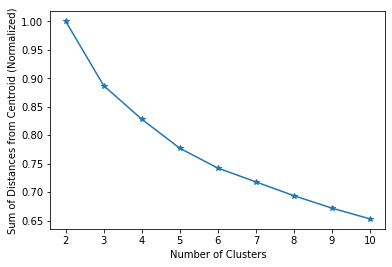

In [7]:
# Plot the sum of distances from centroid vs the number of clusters
define_number_of_clusters(lt_dim, save_data_path)

In [13]:
# train k-medoids for 5 clusters
clustering_model = KMedoids(n_clusters=5, random_state=1, method='pam')
clustering_model.fit(lt_dim)

# save k-medoids clustering model
with open(os.path.join(parent_folder,"Results/AE_k-medoids/kmedoids.pkl"), 'wb') as out:
    pickle.dump(clustering_model, out)

In [7]:
# load the trained k-medoids algorithm
clustering_model = pickle.load(open(os.path.join(parent_folder,"Results/AE_k-medoids/kmedoids.pkl"), 'rb'))
try:
    clusters = clustering_model.predict(lt_dim)
except NotFittedError as error:
    print(error)
    clusters = clustering_model.fit_predict(lt_dim)

# Find the strain curves in time domain that correspond to the centroids of the clusters in the latent space
representative_centers = restore_representatives(clustering_model, lt_dim, deformation)

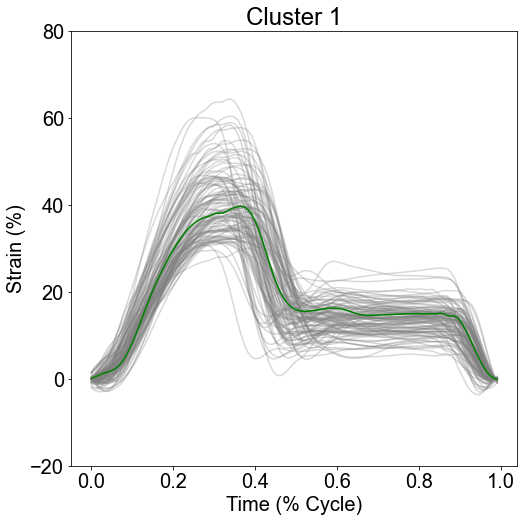

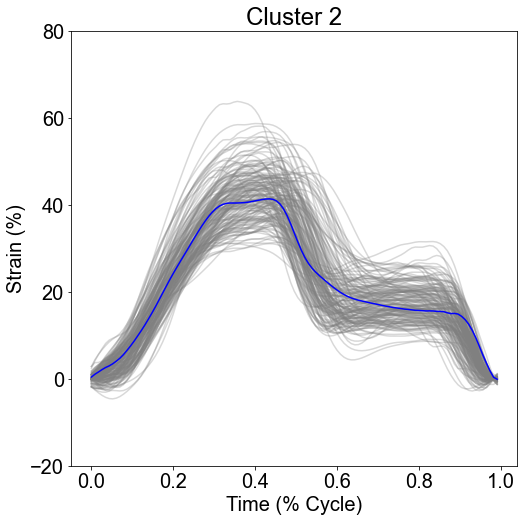

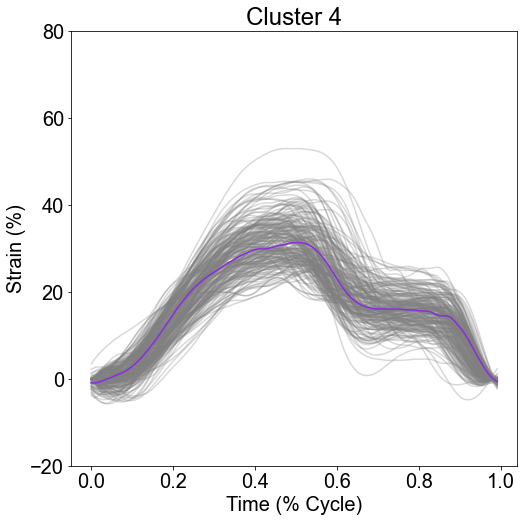

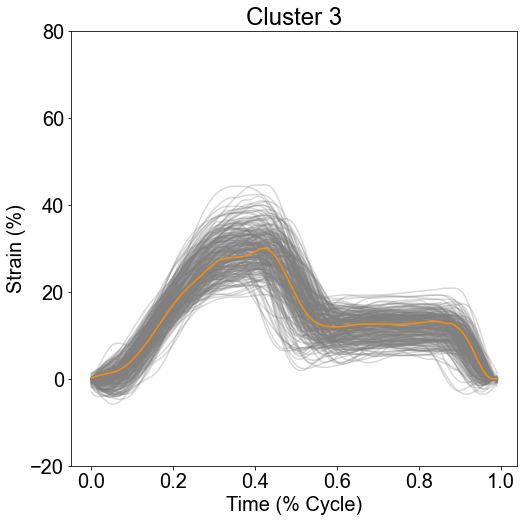

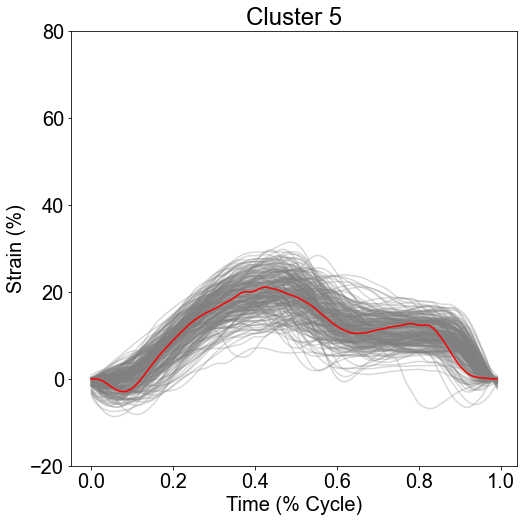

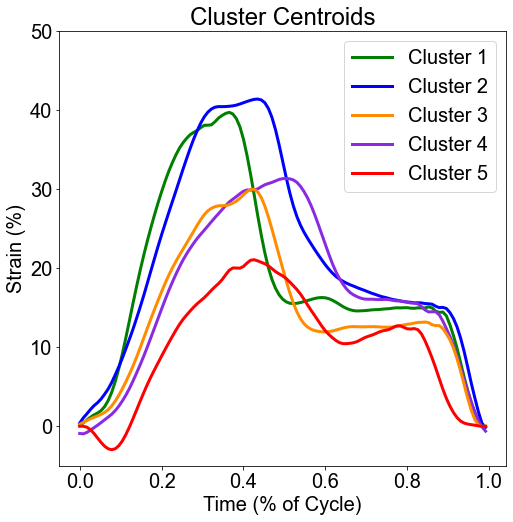

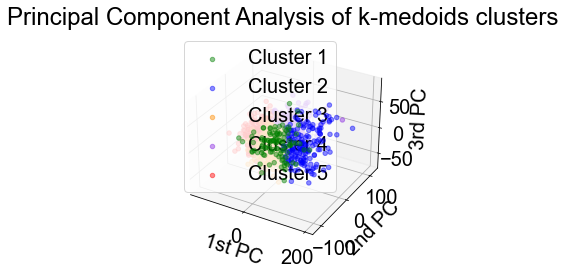

C:\Users\vagge\Desktop\Deformation Curves\VAE\utils.py:156: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

C:\Users\vagge\Desktop\Deformation Curves\VAE\utils.py:165: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

100%|██████████| 944/944 [00:54<00:00, 17.35it/s]


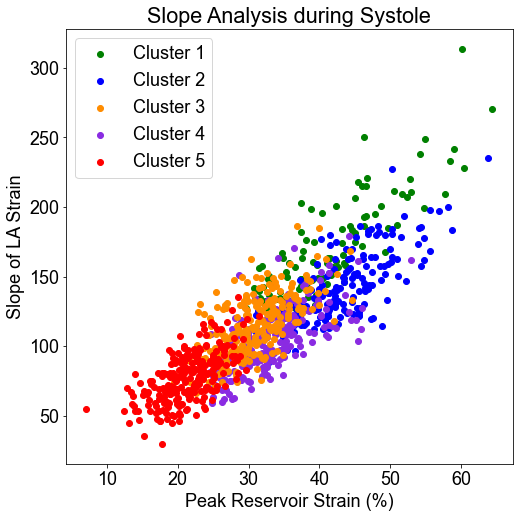

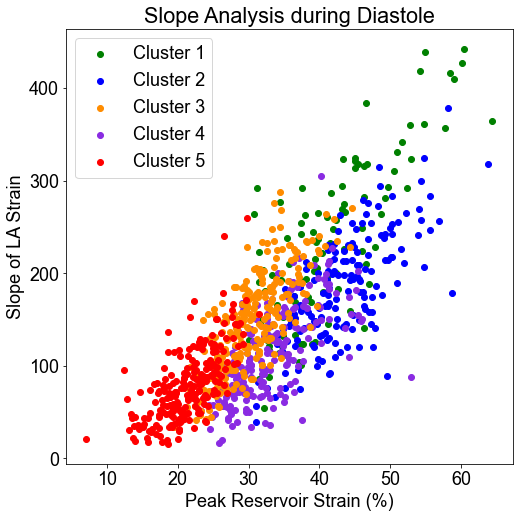

In [8]:
# plots the output (reconstructed train traces) of the AE Network for all the strain traces
reconstruct_curves(autoencoder, deformation, patient_id, reference_time, save_data_path)

# groups the patients' ids per cluster. Returns a list
clustered_id = analyze_patient(clusters, patient_id)

# writes an excel file with the patient's ID and its assigned cluster label
write2excel(clusters, patient_id, save_data_path)

# plots the strain traces grouped per cluster with Matplotlib and plotly. Matplotlib produces png and svg files.
visualize_clustering_results(reference_time, deformation, clustered_id, clusters, patient_id, representative_centers,
                             save_data_path)

# plot the first three principal components of the strain curves
plot_pca(clusters, deformation, patient_id, save_data_path)

# plots the gradient of the Strain traces with Matplotlib and plotly.
plot_gradients(deformation, reference_time, clusters, clustered_id, patient_id, save_data_path)

# calculate the slopes of the strain curves by fitting a linear Regression model
systolic, diastolic = calculate_slopes(deformation, reference_time, patient_id, save_data_path)

# plots the slopes of the Strain traces
plot_slopes(deformation, clusters, clustered_id, patient_id, systolic, diastolic, save_data_path)
